## <font color='darkblue'>Preface</font>
([article source](https://machinelearningmastery.com/model-based-outlier-detection-and-removal-in-python/)) <font size='3ptx'>**The presence of outliers in a classification or regression dataset can result in a poor fit and lower predictive modeling performance.**</font>

**Identifying and removing outliers is challenging with simple statistical methods for most machine learning datasets given the large number of input variables**. Instead, automatic outlier detection methods can be used in the modeling pipeline and compared, just like other data preparation transforms that may be applied to the dataset.

**In this tutorial, you will discover how to use automatic outlier detection and removal to improve machine learning predictive modeling performance.** After completing this tutorial, you will know:
* Automatic outlier detection models provide an alternative to statistical techniques with a larger number of input variables with complex and unknown inter-relationships.
* How to correctly apply automatic outlier detection and removal to the training dataset only to avoid data leakage.
* How to evaluate and compare predictive modeling pipelines with outliers removed from the training dataset.

### <font color='darkgreen'>Tutorial Overview</font>
This tutorial is divided into three parts; they are:
1. <font size='3ptx'>[**Outlier Detection and Removal**](#sect1)</font>
2. <font size='3ptx'>[**Dataset and Performance Baseline**](#sect2)</font>
    1. [**House Price Regression Dataset**](#sect2_1)
    2. [**Baseline Model Performance**](#sect2_2)
3. <font size='3ptx'>[**Automatic Outlier Detection**](#sect3)</font>
    1. [**Isolation Forest**](#sect3_1)
    2. [**Minimum Covariance Determinant**](#sect3_2)
    3. [**Local Outlier Factor**](#sect3_3)
    4. [**One-Class SVM**](#sect3_4)

### <font color='darkgreen'>Required Packages</font>

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.decomposition import PCA

<a id='sect1'></a>
## <font color='darkblue'>Outlier Detection and Removal</font>
**[Outliers](https://machinelearningmastery.com/how-to-use-statistics-to-identify-outliers-in-data/) are observations in a dataset that don’t fit in some way.**

Perhaps the most common or familiar type of outlier is the observations that are far from the rest of the observations or the center of mass of observations. This is easy to understand when we have one or two variables and we can visualize the data as a histogram or scatter plot, although it becomes very challenging when we have many input variables defining a high-dimensional input feature space.

In this case, simple statistical methods for identifying outliers can break down, such as methods that use standard deviations or the [**interquartile range**](https://en.wikipedia.org/wiki/Interquartile_range).

**It can be important to identify and remove outliers from data when training machine learning algorithms for predictive modeling.**

Outliers can skew statistical measures and data distributions, providing a misleading representation of the underlying data and relationships. Removing outliers from training data prior to modeling can result in a better fit of the data and, in turn, more skillful predictions.

Thankfully, **there are a variety of automatic model-based methods for identifying outliers in input data. Importantly, each method approaches the definition of an outlier is slightly different ways, providing alternate approaches to preparing a training dataset that can be evaluated and compared**, just like any other data preparation step in a modeling pipeline.

Before we dive into automatic outlier detection methods, let’s first select a standard machine learning dataset that we can use as the basis for our investigation.

<a id='sect2'></a>
## <font color='darkblue'>Dataset and Performance Baseline</font>
**In this section, we will first select a standard machine learning dataset and establish a baseline in performance on this dataset.**

This will provide the context for exploring the outlier identification and removal method of data preparation in the next section.

<a id='sect2_1'></a>
### <font color='darkgreen'>House Price Regression Dataset</font>
**We will use the house price regression dataset.**

This dataset has 13 input variables that describe the properties of the house and suburb and requires the prediction of the median value of houses in the suburb in thousands of dollars.

You can learn more about the dataset here:
* [House Price Dataset (housing.csv)](https://raw.githubusercontent.com/jbrownlee/Datasets/master/housing.csv)
* [House Price Dataset Description (housing.names)](https://raw.githubusercontent.com/jbrownlee/Datasets/master/housing.names)

No need to download the dataset as we will download it automatically as part of our worked examples. Open the dataset and review the raw data. The first few rows of data are listed below.
```csv
0.00632,18.00,2.310,0,0.5380,6.5750,65.20,4.0900,1,296.0,15.30,396.90,4.98,24.00
0.02731,0.00,7.070,0,0.4690,6.4210,78.90,4.9671,2,242.0,17.80,396.90,9.14,21.60
0.02729,0.00,7.070,0,0.4690,7.1850,61.10,4.9671,2,242.0,17.80,392.83,4.03,34.70
0.03237,0.00,2.180,0,0.4580,6.9980,45.80,6.0622,3,222.0,18.70,394.63,2.94,33.40
0.06905,0.00,2.180,0,0.4580,7.1470,54.20,6.0622,3,222.0,18.70,396.90,5.33,36.20
...
```

We can see that it is a regression predictive modeling problem with numerical input variables, each of which has different scales.

The dataset has many numerical input variables that have unknown and complex relationships. We don’t know that outliers exist in this dataset, although we may guess that some outliers may be present.

The example below loads the dataset and splits it into the input and output columns, splits it into train and test datasets, then summarizes the shapes of the data arrays.

In [10]:
# load the dataset
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/housing.csv'
df = read_csv(url, header=None)

# retrieve the array
data = df.values

# split into input and output elements
X, y = data[:, :-1], data[:, -1]

# summarize the shape of the dataset
print(X.shape, y.shape)

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

# summarize the shape of the train and test sets
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(506, 13) (506,)
(339, 13) (167, 13) (339,) (167,)


For visualization on the selected outliers, we use [**PCA**](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) to reduce the feature space from 4 to 2:

In [46]:
pca = PCA(n_components=2)
pca.fit(X_train)
X_train_2dim = pca.transform(X_train)
X_train_2dim.shape

(339, 2)

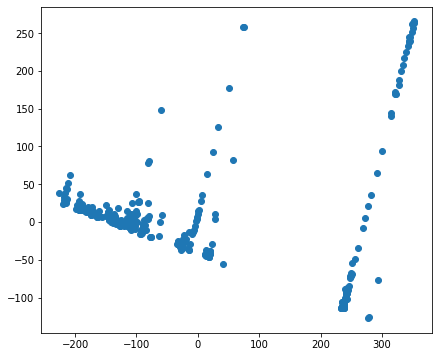

In [98]:
plt.rcParams['figure.figsize'] = [7, 6]
plt.scatter(x=X_train_2dim[:, 0], y=X_train_2dim[:, 1])

In [81]:
def outliner_scatter_plot(marks, figsize=(7, 6)):
    plt.rcParams['figure.figsize'] = figsize
    X_train_2dim_df = pd.DataFrame(X_train_2dim, columns=['f1', 'f2'])
    X_train_2dim_df['inliner'] = mask
    X_train_2dim_df['inliner'] = X_train_2dim_df.inliner.astype(int)
    # X_train_2dim_df.sample(n=10)
    ax = sns.scatterplot(x="f1", y="f2", data=X_train_2dim_df, hue="inliner")
    return ax

Next, let’s evaluate a model on this dataset and establish a baseline in performance.

<a id='sect2_2'></a>
### <font color='darkgreen'>Baseline Model Performance</font>
**It is a regression predictive modeling problem, meaning that we will be predicting a numeric value. All input variables are also numeric.**

In this case, we will fit a linear regression algorithm and evaluate model performance by training the model on the test dataset and making a prediction on the test data and evaluate the predictions using the mean absolute error (<font color='brown'>MAE</font>).

The complete example of evaluating a linear regression model on the dataset is listed below.

In [5]:
# fit the model
model = LinearRegression()
model.fit(X_train, y_train)

# evaluate the model
yhat = model.predict(X_test)

# evaluate predictions
mae = mean_absolute_error(y_test, yhat)
print('MAE: %.3f' % mae)

MAE: 3.417


In this case, we can see that **the model achieved a MAE of about 3.417. This provides a baseline in performance to which we can compare different outlier identification and removal procedures.**

<a id='sect3'></a>
## <font color='darkblue'>Automatic Outlier Detection</font>
**The [scikit-learn library](https://scikit-learn.org/stable/modules/outlier_detection.html) provides a number of built-in automatic methods for identifying outliers in data.**

In this section, we will review four methods and compare their performance on the house price dataset.

**Each method will be defined, then fit on the training dataset. The fit model will then predict which examples in the training dataset are outliers and which are not** (<font color='brown'>so-called inliers</font>). The outliers will then be removed from the training dataset, then the model will be fit on the remaining examples and evaluated on the entire test dataset.

**It would be invalid to fit the outlier detection method on the entire training dataset as this would result in [data leakage](https://machinelearningmastery.com/data-leakage-machine-learning/)**. That is, the model would have access to data (<font color='brown'>or information about the data</font>) in the test set not used to train the model. This may result in an optimistic estimate of model performance.

We could attempt to detect outliers on “new data” such as the test set prior to making a prediction, but then **what do we do if outliers are detected?**

One approach might be to return a “None” indicating that the model is unable to make a prediction on those outlier cases. This might be an interesting extension to explore that may be appropriate for your project.

<a id='sect3_1'></a>
### <font color='darkgreen'>Isolation Forest</font>
**[Isolation Forest](https://en.wikipedia.org/wiki/Isolation_forest), or iForest for short, is a tree-based anomaly detection algorithm.**

It is based on modeling the normal data in such a way as to isolate anomalies that are both few in number and different in the feature space.
> … our proposed method takes advantage of two anomalies’ quantitative properties: i) they are the minority consisting of fewer instances and ii) they have attribute-values that are very different from those of normal instances. <br/><br/>
> [**— Isolation Forest, 2008.**](https://ieeexplore.ieee.org/abstract/document/4781136)

The scikit-learn library provides an implementation of Isolation Forest in the [**IsolationForest class**](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html).

Perhaps the most important hyperparameter in the model is the “<font color='violet'>contamination</font>” argument, which is used to help estimate the number of outliers in the dataset. This is a value between 0.0 and 0.5 and by default is set to 0.1.

In [94]:
# identify outliers in the training dataset
iso = IsolationForest(contamination=0.1)
yhat = iso.fit_predict(X_train)

Once identified, we can **remove the outliers from the training dataset.**

In [95]:
# select all rows that are not outliers
mask = yhat != -1
X_train_iso, y_train_iso = X_train[mask, :], y_train[mask]

# summarize the shape of the updated training dataset
print(f"{len(X_train) - len(X_train_iso)} outlier(s) being removed!")

34 outlier(s) being removed!


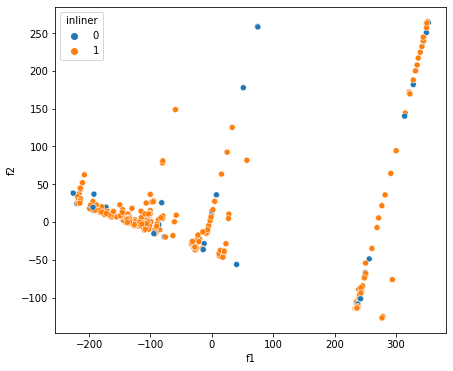

In [96]:
ax = outliner_scatter_plot(mask)

then is to re-train the regression model with refined data set (removed outliers):

In [97]:
# fit the model
model = LinearRegression()
model.fit(X_train_iso, y_train_iso)

# evaluate the model
yhat = model.predict(X_test)

# evaluate predictions
mae = mean_absolute_error(y_test, yhat)
print('MAE: %.3f' % mae)

MAE: 3.195


In this case, we can see that that model identified and removed 34 outliers and achieved a MAE of about 3.195, an improvement over the baseline that achieved a score of about 3.417.

<a id='sect3_2'></a>
### <font color='darkgreen'>Minimum Covariance Determinant</font>
**If the input variables have a Gaussian distribution, then simple statistical methods can be used to detect outliers.**

For example, if the dataset has two input variables and both are Gaussian, then the feature space forms a multi-dimensional Gaussian and knowledge of this distribution can be used to identify values far from the distribution.

This approach can be generalized by defining a hypersphere (ellipsoid) that covers the normal data, and data that falls outside this shape is considered an outlier. An efficient implementation of this technique for multivariate data is known as the <font color='darkblue'>**Minimum Covariance Determinant**</font>, or MCD for short.
> The Minimum Covariance Determinant (MCD) method is a highly robust estimator of multivariate location and scatter, for which a fast algorithm is available. […] It also serves as a convenient and efficient tool for outlier detection. <br/><br/>
> [**— Minimum Covariance Determinant and Extensions, 2017.**](https://arxiv.org/abs/1709.07045)

The scikit-learn library provides access to this method via the [**EllipticEnvelope**](https://scikit-learn.org/stable/modules/generated/sklearn.covariance.EllipticEnvelope.html) class.

It provides the “<font color='violet'>contamination</font>” argument that defines the expected ratio of outliers to be observed in practice. In this case, we will set it to a value of 0.01, found with a little trial and error.

In [90]:
# identify outliers in the training dataset
ee = EllipticEnvelope(contamination=0.1)
yhat = ee.fit_predict(X_train)

Once identified, the outliers can be removed from the training dataset as we did in the prior example.

In [91]:
# select all rows that are not outliers
mask = yhat != -1
X_train_mcd, y_train_mcd = X_train[mask, :], y_train[mask]

# summarize the shape of the updated training dataset
print(f"{len(X_train) - len(X_train_mcd)} outlier(s) being removed!")

34 outlier(s) being removed!


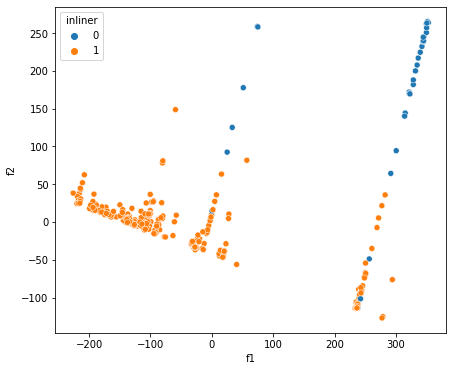

In [92]:
ax = outliner_scatter_plot(mask)

In [93]:
# fit the model
model = LinearRegression()
model.fit(X_train_mcd, y_train_mcd)
# evaluate the model
yhat = model.predict(X_test)
# evaluate predictions
mae = mean_absolute_error(y_test, yhat)
print('MAE: %.3f' % mae)

MAE: 3.662


In this case, we can see that the elliptical envelope method identified and removed only 4 outliers, resulting in a drop in MAE from 3.417 with the baseline to 3.662.

<a id='sect3_3'></a>
### <font color='darkgreen'>Local Outlier Factor</font>
**A simple approach to identifying outliers is to locate those examples that are far from the other examples in the feature space.**

This can work well for feature spaces with low dimensionality (<font color='brown'>few features</font>), although it can become less reliable as the number of features is increased, referred to as the curse of dimensionality.

The local outlier factor, or LOF for short, is a technique that attempts to harness the idea of nearest neighbors for outlier detection. **Each example is assigned a scoring of how isolated or how likely it is to be outliers based on the size of its local neighborhood. Those examples with the largest score are more likely to be outliers.**
> We introduce a local outlier (LOF) for each object in the dataset, indicating its degree of outlier-ness. <br/><br/>
> [**— LOF: Identifying Density-based Local Outliers, 2000.**](https://dl.acm.org/citation.cfm?id=335388)

The scikit-learn library provides an implementation of this approach in the [**LocalOutlierFactor class**](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html).

The model provides the “<font color='violet'>contamination</font>” argument, that is the expected percentage of outliers in the dataset, be indicated and defaults to 0.1.

In [30]:
# identify outliers in the training dataset
lof = LocalOutlierFactor()
yhat = lof.fit_predict(X_train)

Then it's time to remove outliers and retrain the model:

In [31]:
# select all rows that are not outliers
mask = yhat != -1
X_train_lof, y_train_lof = X_train[mask, :], y_train[mask]

# summarize the shape of the updated training dataset
print(f"{len(X_train) - len(X_train_lof)} outlier(s) being removed!")

34 outlier(s) being removed!


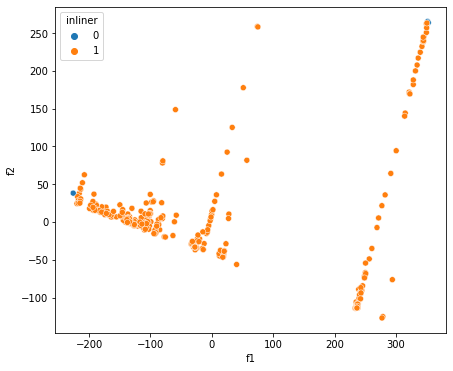

In [84]:
ax = outliner_scatter_plot(mask)

In [32]:
# fit the model
model = LinearRegression()
model.fit(X_train_lof, y_train_lof)

# evaluate the model
yhat = model.predict(X_test)

# evaluate predictions
mae = mean_absolute_error(y_test, yhat)
print('MAE: %.3f' % mae)

MAE: 3.356


In this case, we can see that the local outlier factor method identified and removed 34 outliers, the same number as isolation forest, resulting in a drop in MAE from 3.417 with the baseline to 3.356. Better, but not as good as isolation forest, suggesting a different set of outliers were identified and removed.

<a id='sect3_4'></a>
### <font color='darkgreen'>One-Class SVM</font>
**The support vector machine, or SVM, algorithm developed initially for binary classification can be used for one-class classification.**

When modeling one class, the algorithm captures the density of the majority class and classifies examples on the extremes of the density function as outliers. This modification of SVM is referred to as [**One-Class SVM**](https://en.wikipedia.org/wiki/One-class_classification).
> … an algorithm that computes a binary function that is supposed to capture regions in input space where the probability density lives (its support), that is, a function such that most of the data will live in the region where the function is nonzero. <br/><br/>
> [**— Estimating the Support of a High-Dimensional Distribution, 2001.**](https://dl.acm.org/citation.cfm?id=1119749)

Although SVM is a classification algorithm and One-Class SVM is also a classification algorithm, it can be used to discover outliers in input data for both regression and classification datasets.

The scikit-learn library provides an implementation of one-class SVM in the [**OneClassSVM class**](https://scikit-learn.org/stable/modules/generated/sklearn.svm.OneClassSVM.html#sklearn.svm.OneClassSVM).

The class provides the “<font color='violet'>nu</font>” argument that specifies the approximate ratio of outliers in the dataset, which defaults to 0.1. In this case, we will set it to 0.01, found with a little trial and error.

In [86]:
# identify outliers in the training dataset
ee = OneClassSVM(nu=0.1)
yhat = ee.fit_predict(X_train)

In [87]:
# select all rows that are not outliers
mask = yhat != -1
X_train_ee, y_train_ee = X_train[mask, :], y_train[mask]

# summarize the shape of the updated training dataset
print(f"{len(X_train) - len(X_train_ee)} outlier(s) being removed!")

34 outlier(s) being removed!


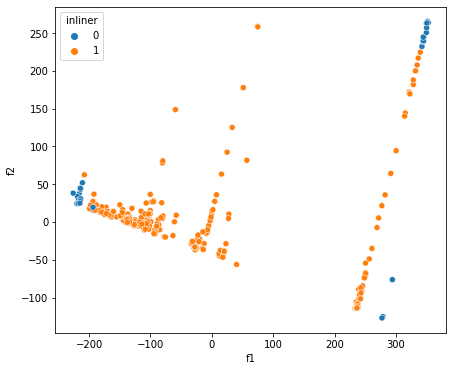

In [88]:
ax = outliner_scatter_plot(mask)

As usual, let's remove outliers and retrain the model:

In [89]:
# fit the model
model = LinearRegression()
model.fit(X_train_ee, y_train_ee)

# evaluate the model
yhat = model.predict(X_test)

# evaluate predictions
mae = mean_absolute_error(y_test, yhat)
print('MAE: %.3f' % mae)

MAE: 3.448


In this case, we can see that only three outliers were identified and removed and the model achieved a MAE of about 3.448, which is not better than the baseline model that achieved 3.417. Perhaps better performance can be achieved with more tuning.